# Survival Probability after a Heart Attack

The dataset was uploaded from https://www.kaggle.com/yukikitayama/survival-analysis/data


Herein we perform survival analysis on the dataset containing information obtained from patients' echocardiogram. Analysis will predict the number of month the person will most likely live after a heart attack. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.impute import SimpleImputer
from scipy import stats
from lifelines import KaplanMeierFitter, CoxPHFitter 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer

## Dataset

In [2]:
data = pd.read_csv('echocardiogram.csv')
data.sample(10)

,survival,alive,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score,wallmotion-index,mult,name,group,aliveat1
73,29.00,0.0,60.0,0.0,0.12,10.2,4.31,15.00,1.670,0.640,name,2,0.0
113,36.00,0.0,61.0,0.0,0.27,9.0,4.06,12.00,1.000,0.857,name,NaN,NaN
81,32.00,0.0,65.0,0.0,0.06,23.6,6.74,12.00,1.090,0.785,name,2,NaN
24,48.00,0.0,64.0,0.0,0.19,5.9,3.48,10.00,1.110,0.640,name,2,NaN
67,0.75,1.0,50.0,0.0,0.14,11.4,4.75,10.00,2.500,0.280,name,2,NaN
70,41.00,0.0,78.0,0.0,0.06,16.1,5.62,13.67,1.367,0.714,name,2,0.0
111,27.00,0.0,62.0,0.0,0.22,12.1,3.92,11.00,1.000,0.785,name,NaN,NaN
65,12.00,0.0,67.0,1.0,0.11,10.3,4.68,11.00,1.000,0.785,name,2,NaN
128,7.50,1.0,64.0,0.0,0.24,12.9,4.72,12.00,1.000,0.857,name,NaN,NaN
27,29.00,0.0,55.0,0.0,NaN,7.0,NaN,2.00,1.000,2.000,name,2,NaN


In [3]:
data.shape

(133, 13)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   survival              130 non-null    float64
 1   alive                 131 non-null    float64
 2   age                   126 non-null    float64
 3   pericardialeffusion   132 non-null    float64
 4   fractionalshortening  124 non-null    float64
 5   epss                  117 non-null    float64
 6   lvdd                  121 non-null    float64
 7   wallmotion-score      128 non-null    float64
 8   wallmotion-index      130 non-null    float64
 9   mult                  129 non-null    float64
 10  name                  131 non-null    object 
 11  group                 110 non-null    object 
 12  aliveat1              75 non-null     float64
dtypes: float64(11), object(2)
memory usage: 13.6+ KB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
survival,130.0,22.182923,15.858267,0.03,7.875,23.500,33.0000,57.00
alive,131.0,0.328244,0.471377,0.00,0.000,0.000,1.0000,1.00
age,126.0,62.813722,8.342110,35.00,57.000,62.000,67.7500,86.00
pericardialeffusion,132.0,0.765152,6.697225,0.00,0.000,0.000,0.0000,77.00
fractionalshortening,124.0,0.216734,0.107513,0.01,0.150,0.205,0.2700,0.61
epss,117.0,12.164769,7.370159,0.00,7.000,11.000,16.1000,40.00
lvdd,121.0,4.763157,0.810013,2.32,4.230,4.650,5.3000,6.78
wallmotion-score,128.0,14.438125,5.018566,2.00,11.000,14.000,16.5000,39.00
wallmotion-index,130.0,1.378000,0.451850,1.00,1.000,1.216,1.5075,3.00
mult,129.0,0.786202,0.225661,0.14,0.714,0.786,0.8570,2.00


In [6]:
data['alive'].value_counts()

0.0    88
1.0    43
Name: alive, dtype: int64

In [7]:
data['pericardialeffusion'].value_counts() # Value "77" is most likely a mistake

0.0     107
1.0      24
77.0      1
Name: pericardialeffusion, dtype: int64

In [8]:
categorical = ['alive', 'pericardialeffusion']

In [9]:
# Check for NaN values
data.isna().sum()


survival                 3
alive                    2
age                      7
pericardialeffusion      1
fractionalshortening     9
epss                    16
lvdd                    12
wallmotion-score         5
wallmotion-index         3
mult                     4
name                     2
group                   23
aliveat1                58
dtype: int64

In [10]:
# Delete feature "name" and "aliveat1"
data.drop(['name', 'aliveat1'], axis=1, inplace=True)

In [11]:
# Feature "group" has two values
data['group'].value_counts()

2       85
1       24
name     1
Name: group, dtype: int64

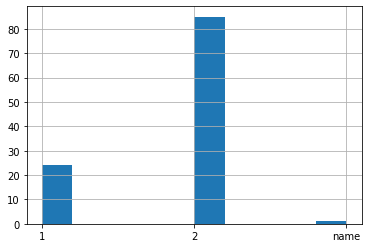

In [12]:
data['group'].hist()

In [13]:
# Value "name" obviously migrated from neighbouring column by mistake. 
# Replace "name" and "NaN" values with the most common value 2 and transform the type of values to integer
data['group'] = data['group'].apply(lambda x: int(x) if (x=='1' or x=='2') else 2)

In [14]:
# Fill NaN values in categorical features with the most common value '0'
for feature in categorical:
    data[feature] = data[feature].apply(lambda x: x if (x==0 or x==1) else 1)

In [15]:
# Fill NaN values with mean 
for feature in data.columns.to_list():
    data[feature] = data[feature].apply(lambda x: data[feature].mean() if str(x)=="nan" else x)

In [16]:
data.sample(10)

,survival,alive,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score,wallmotion-index,mult,group
56,10.00,0.0,66.000000,0.0,0.290,15.600,6.150,14.0,1.00,1.000,2
2,16.00,0.0,55.000000,0.0,0.260,4.000,3.420,14.0,1.00,1.000,1
128,7.50,1.0,64.000000,0.0,0.240,12.900,4.720,12.0,1.00,0.857,2
3,57.00,0.0,60.000000,0.0,0.253,12.062,4.603,16.0,1.45,0.788,1
23,5.00,1.0,71.000000,0.0,0.170,0.000,4.650,8.0,1.00,0.570,1
78,0.03,1.0,62.813722,0.0,0.260,19.400,4.770,21.0,2.10,0.714,2
84,0.75,1.0,78.000000,0.0,0.050,10.000,4.440,15.0,1.36,0.786,2
77,0.25,1.0,68.000000,0.0,0.220,21.700,4.850,15.0,1.15,0.928,2
67,0.75,1.0,50.000000,0.0,0.140,11.400,4.750,10.0,2.50,0.280,2
9,25.00,0.0,54.000000,0.0,0.140,13.000,4.490,15.5,1.19,0.930,1


## Data correlation


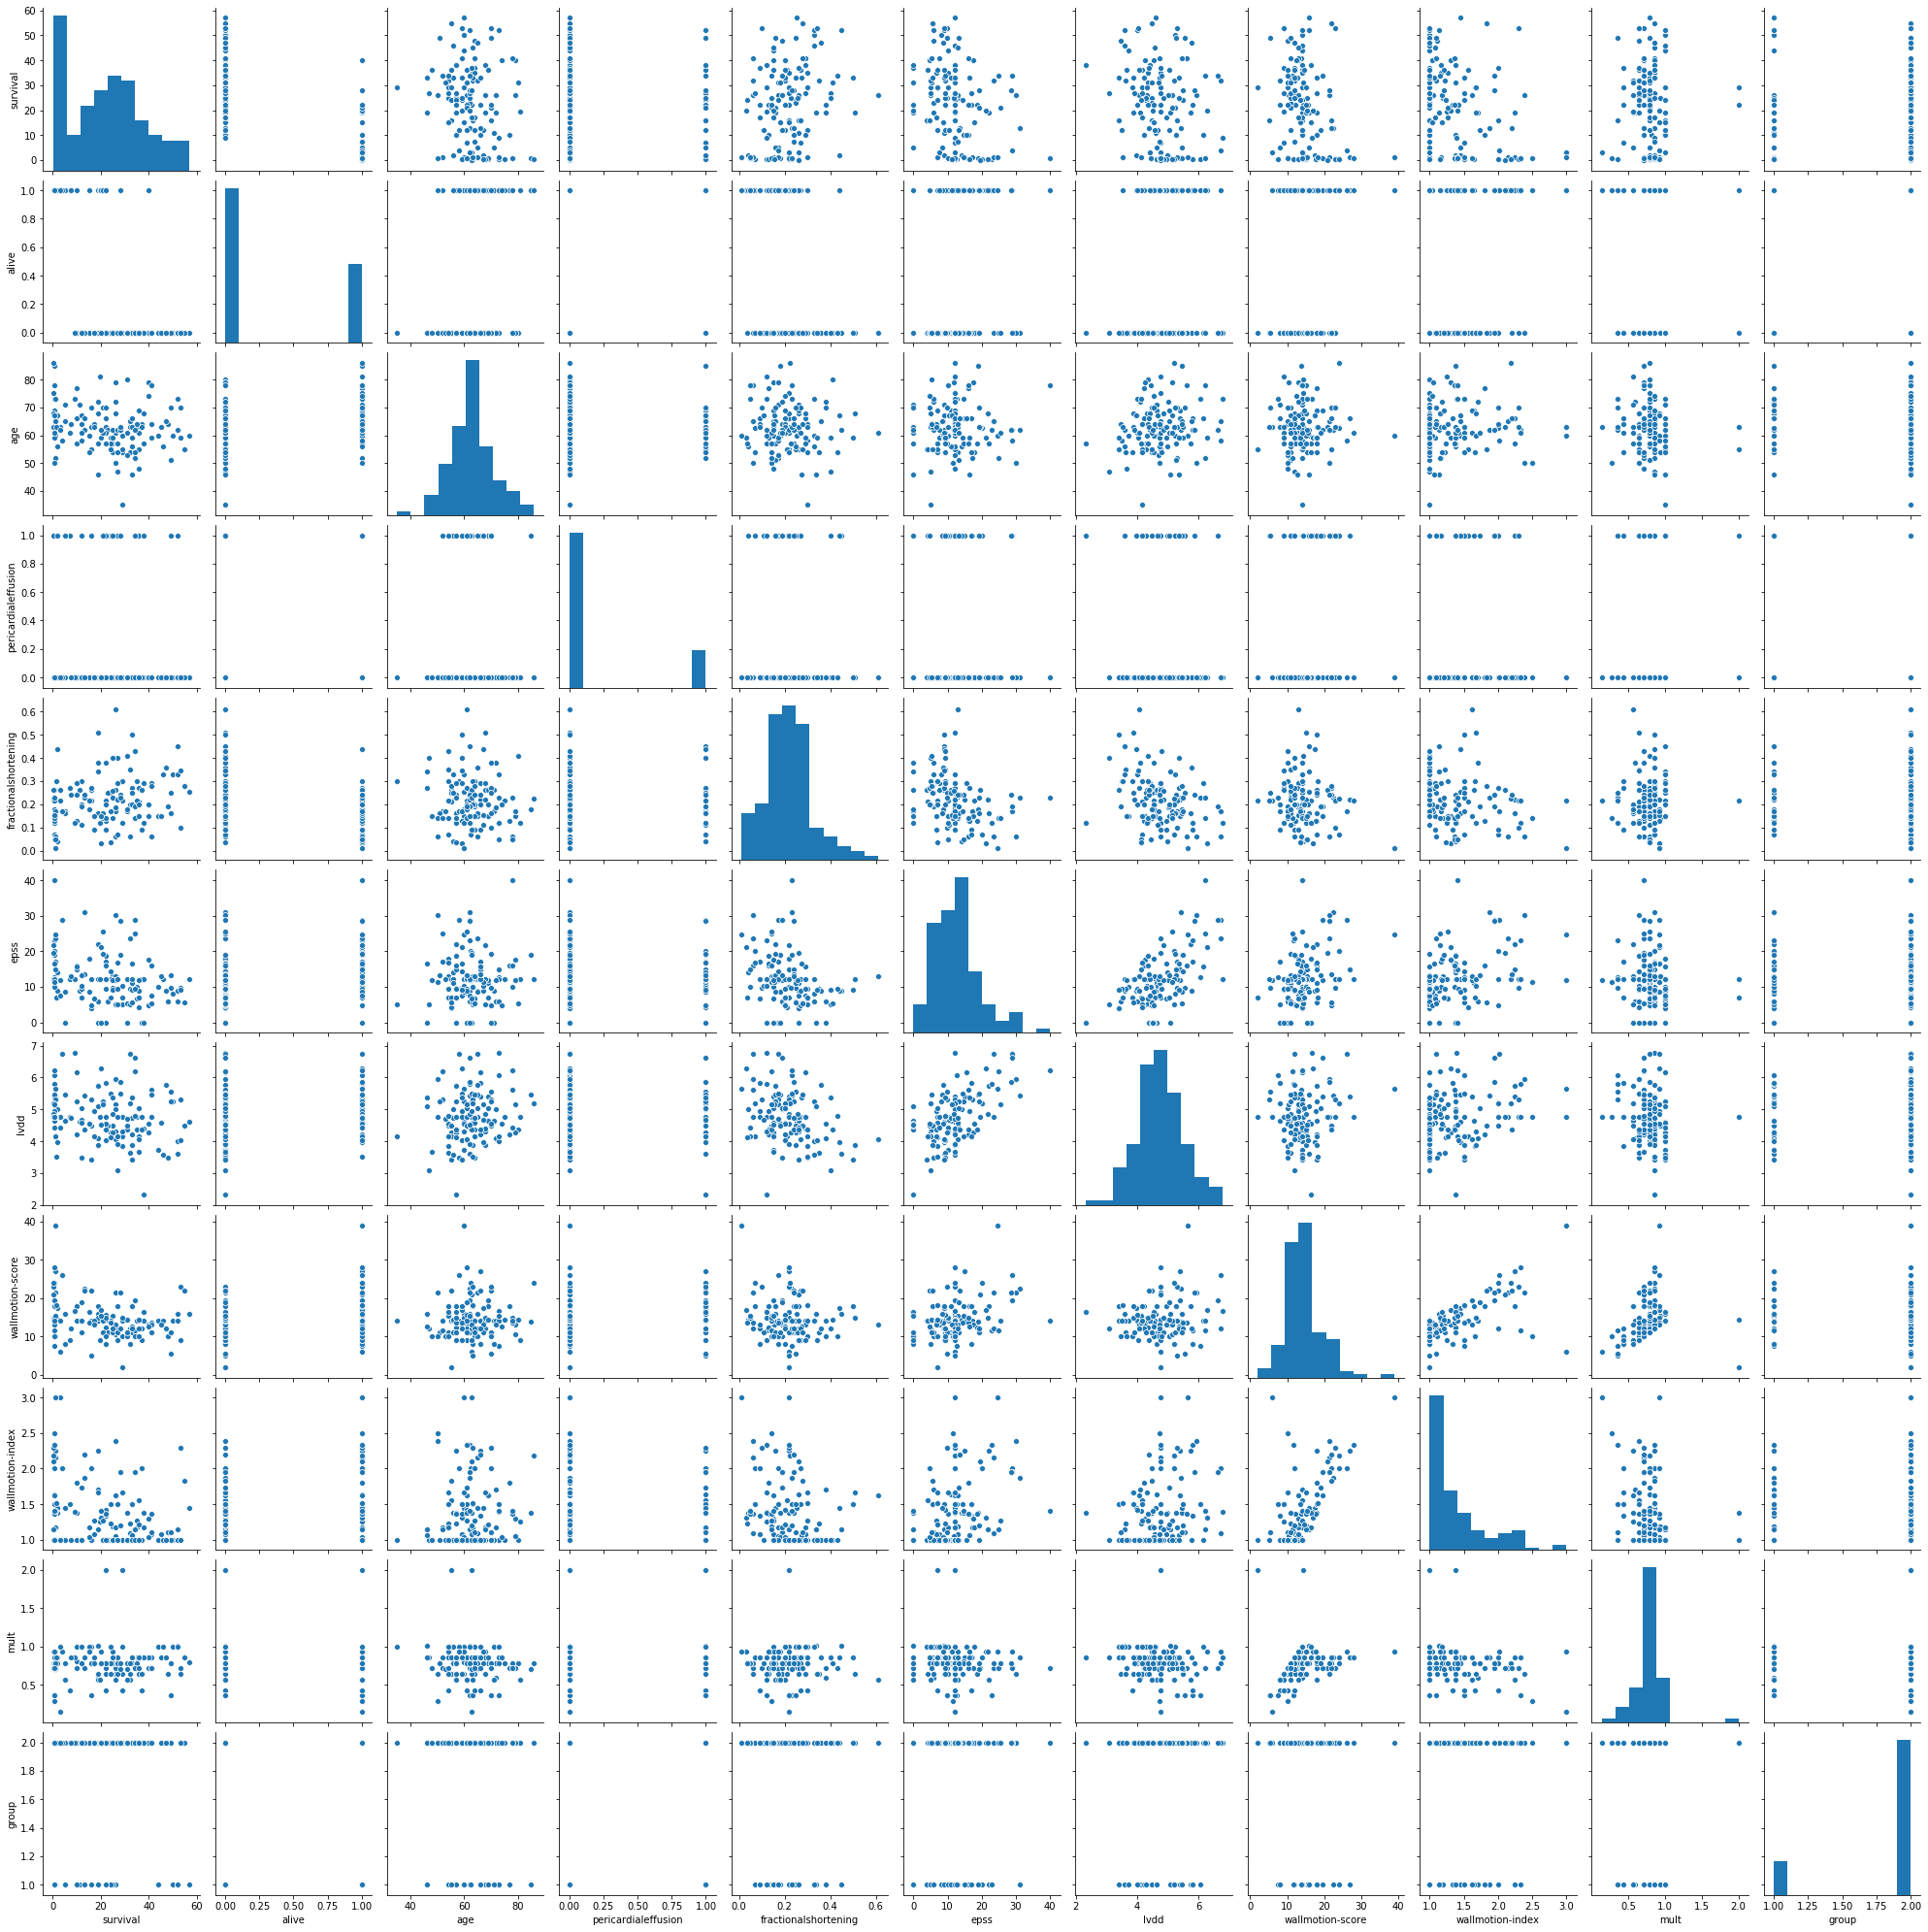

In [17]:
sns.pairplot(data)

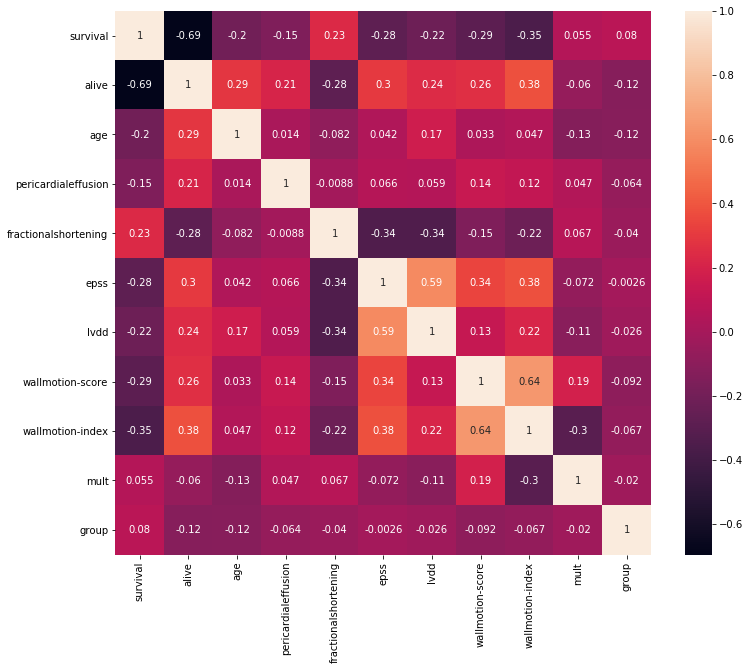

In [18]:
fig, ax = plt.subplots(figsize=(12,10))  
sns.heatmap(data.corr(), annot=True)

In [19]:
data_sc = data.drop('survival', axis=1)

In [20]:
StandardScaler().fit_transform(data_sc)

array([[-7.15096942e-01,  1.01223508e+00, -4.92940822e-01, ...,
        -8.49431736e-01,  9.65761238e-01, -2.13111864e+00],
       [-7.15096942e-01,  1.13588530e+00, -4.92940822e-01, ...,
         7.23589997e-01, -8.95307590e-01, -2.13111864e+00],
       [-7.15096942e-01, -9.66168501e-01, -4.92940822e-01, ...,
        -8.49431736e-01,  9.65761238e-01, -2.13111864e+00],
       ...,
       [-7.15096942e-01,  7.64934631e-01, -4.92940822e-01, ...,
        -3.77525216e-01,  3.19807737e-01,  4.69237132e-01],
       [-7.15096942e-01, -7.18868054e-01, -4.92940822e-01, ...,
        -4.04491303e-02, -9.10434815e-04,  4.69237132e-01],
       [-7.15096942e-01, -1.00616935e-01, -4.92940822e-01, ...,
         6.96623910e-02, -9.10434815e-04,  4.69237132e-01]])

## Data censoring

The dataset contains patients who are alive by the time the data were collected. This data had to be censored.

In [21]:
data['alive'].value_counts()

0.0    88
1.0    45
Name: alive, dtype: int64

In [22]:
# New feature 'dead'
data_sc['dead'] = data_sc['alive'].apply(lambda x: 0 if x==1 else 1)
data_sc.drop('alive', axis=1, inplace=True)

## Kaplan-Meier Curve

Text(0, 0.5, 'Survival probability')

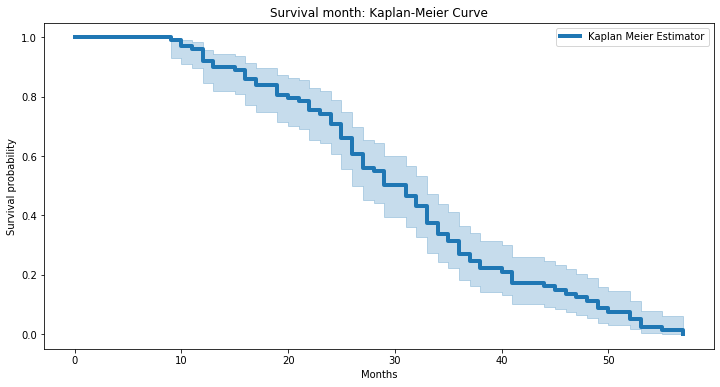

In [23]:
kmf = KaplanMeierFitter()

kmf.fit(data.survival, event_observed = data_sc['dead'], label = 'Kaplan Meier Estimator')

kmf.plot(linewidth=4, figsize=(12, 6))
plt.title('Survival month: Kaplan-Meier Curve')
plt.xlabel('Months')
plt.ylabel('Survival probability')

In [24]:
# Kaplan-Meier curve by "group"
data_sc['group'].value_counts()

2    109
1     24
Name: group, dtype: int64

Text(0, 0.5, 'Survival probability')

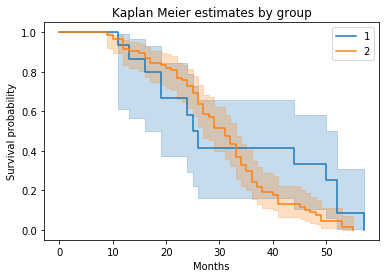

In [25]:
group = data_sc['group'] < 2
ax = plt.subplot(111)
kmf.fit(data['survival'][group], event_observed = data_sc['dead'][group], label = '1')
kmf.plot(ax = ax)
kmf.fit(data['survival'][~group], event_observed = data_sc['dead'][~group], label = '2')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimates by group")
plt.xlabel("Months")
plt.ylabel("Survival probability")

In [26]:
# Kaplan-Meier curve by "age"
statistics.median(data_sc['age'])

62.528999999999996

Text(0, 0.5, 'Survival probability')

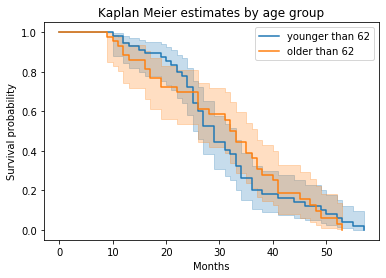

In [27]:
age_group = data_sc['age'] < statistics.median(data_sc['age'])
ax = plt.subplot(111)
kmf.fit(data['survival'][age_group], event_observed = data_sc['dead'][age_group], label = 'younger than 62')
kmf.plot(ax = ax)
kmf.fit(data['survival'][~age_group], event_observed = data_sc['dead'][~age_group], label = 'older than 62')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimates by age group")
plt.xlabel("Months")
plt.ylabel("Survival probability")

In [28]:
statistics.median(data_sc['wallmotion-index'])

1.23

Text(0, 0.5, 'Survival probability')

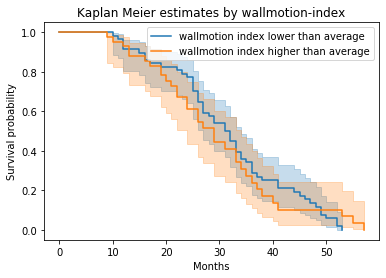

In [29]:
w_group = data_sc['wallmotion-index'] < statistics.median(data_sc['wallmotion-index'])
ax = plt.subplot(111)
kmf.fit(data['survival'][w_group], event_observed = data_sc['dead'][w_group], label = 'wallmotion index lower than average')
kmf.plot(ax = ax)
kmf.fit(data['survival'][~w_group], event_observed = data_sc['dead'][~w_group], label = 'wallmotion index higher than average')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimates by wallmotion-index")
plt.xlabel("Months")
plt.ylabel("Survival probability")

## Conclusions
From the collected data one can conclude that the survival probability is maximum during the first 10 months after a heart attack, then it starts to decrease gradualy and reaches its minimum after 50 month. 

Further the survival probability was estimated by several different groups. 

Thus, patients who were assigned to the group 1 have higher survival probability after 30 months than those who were assigned to the group 2. 

Patients younger than 62 have a bit higher survival probability during the first 25 month. It decreases dramaticaly between 25 and 40 months. 

Patients with wallmotion index higher than average have in general a lightly lower survival probability.

Because the number of samples is quite small, as a general suggestion, more data should be collected to make more accurate estimation.
 